In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pathlib import Path
import numpy as np
from astropy.time import Time
from astropy.io import fits
import astropy.units as u

In [8]:
def plot_orders(wave, spec, blaze=None, title=None):
    
    orders = spec.shape[0]

    fig, ax = plt.subplots(5, 6, figsize=(18, 8), dpi=300)
    fig.tight_layout(pad=2.0)

    for i, order in enumerate(range(orders)):
        ax_row = i // 6  # Calculate the row index of the current subplot
        ax_col = i % 6   # Calculate the column index of the current subplot
        
        ax[ax_row, ax_col].plot(wave[order], spec[order], alpha=0.7)

        if blaze is not None:
            ax[ax_row, ax_col].plot(wave[order], blaze[order], alpha=0.7)

        ax[ax_row, ax_col].set_title('Order {}'.format(order))

    # plt.suptitle('H band Blaze Function & telluric-improved')
    plt.suptitle(title)
    # plt.suptitle('K band Blaze Function & telluric-improved \n order 25 ignored, tiny flux')

    plt.tight_layout()
    plt.show()
        

## Spectrum

### H band

In [19]:
path = '/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/raw_red_data/reduced'
# extract the spectrum 2d data
p=path/Path('SDCH_20230628_0026.spec.fits')
with fits.open(p) as hdu:
    hdu.info()
    h = hdu[0].header
    spec_h = hdu[0].data
    wave_h = hdu[1].data

Filename: /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/raw_red_data/reduced/SDCH_20230628_0026.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     310   (2048, 28)   float32   
  1                1 ImageHDU       204   (2048, 28)   float64   


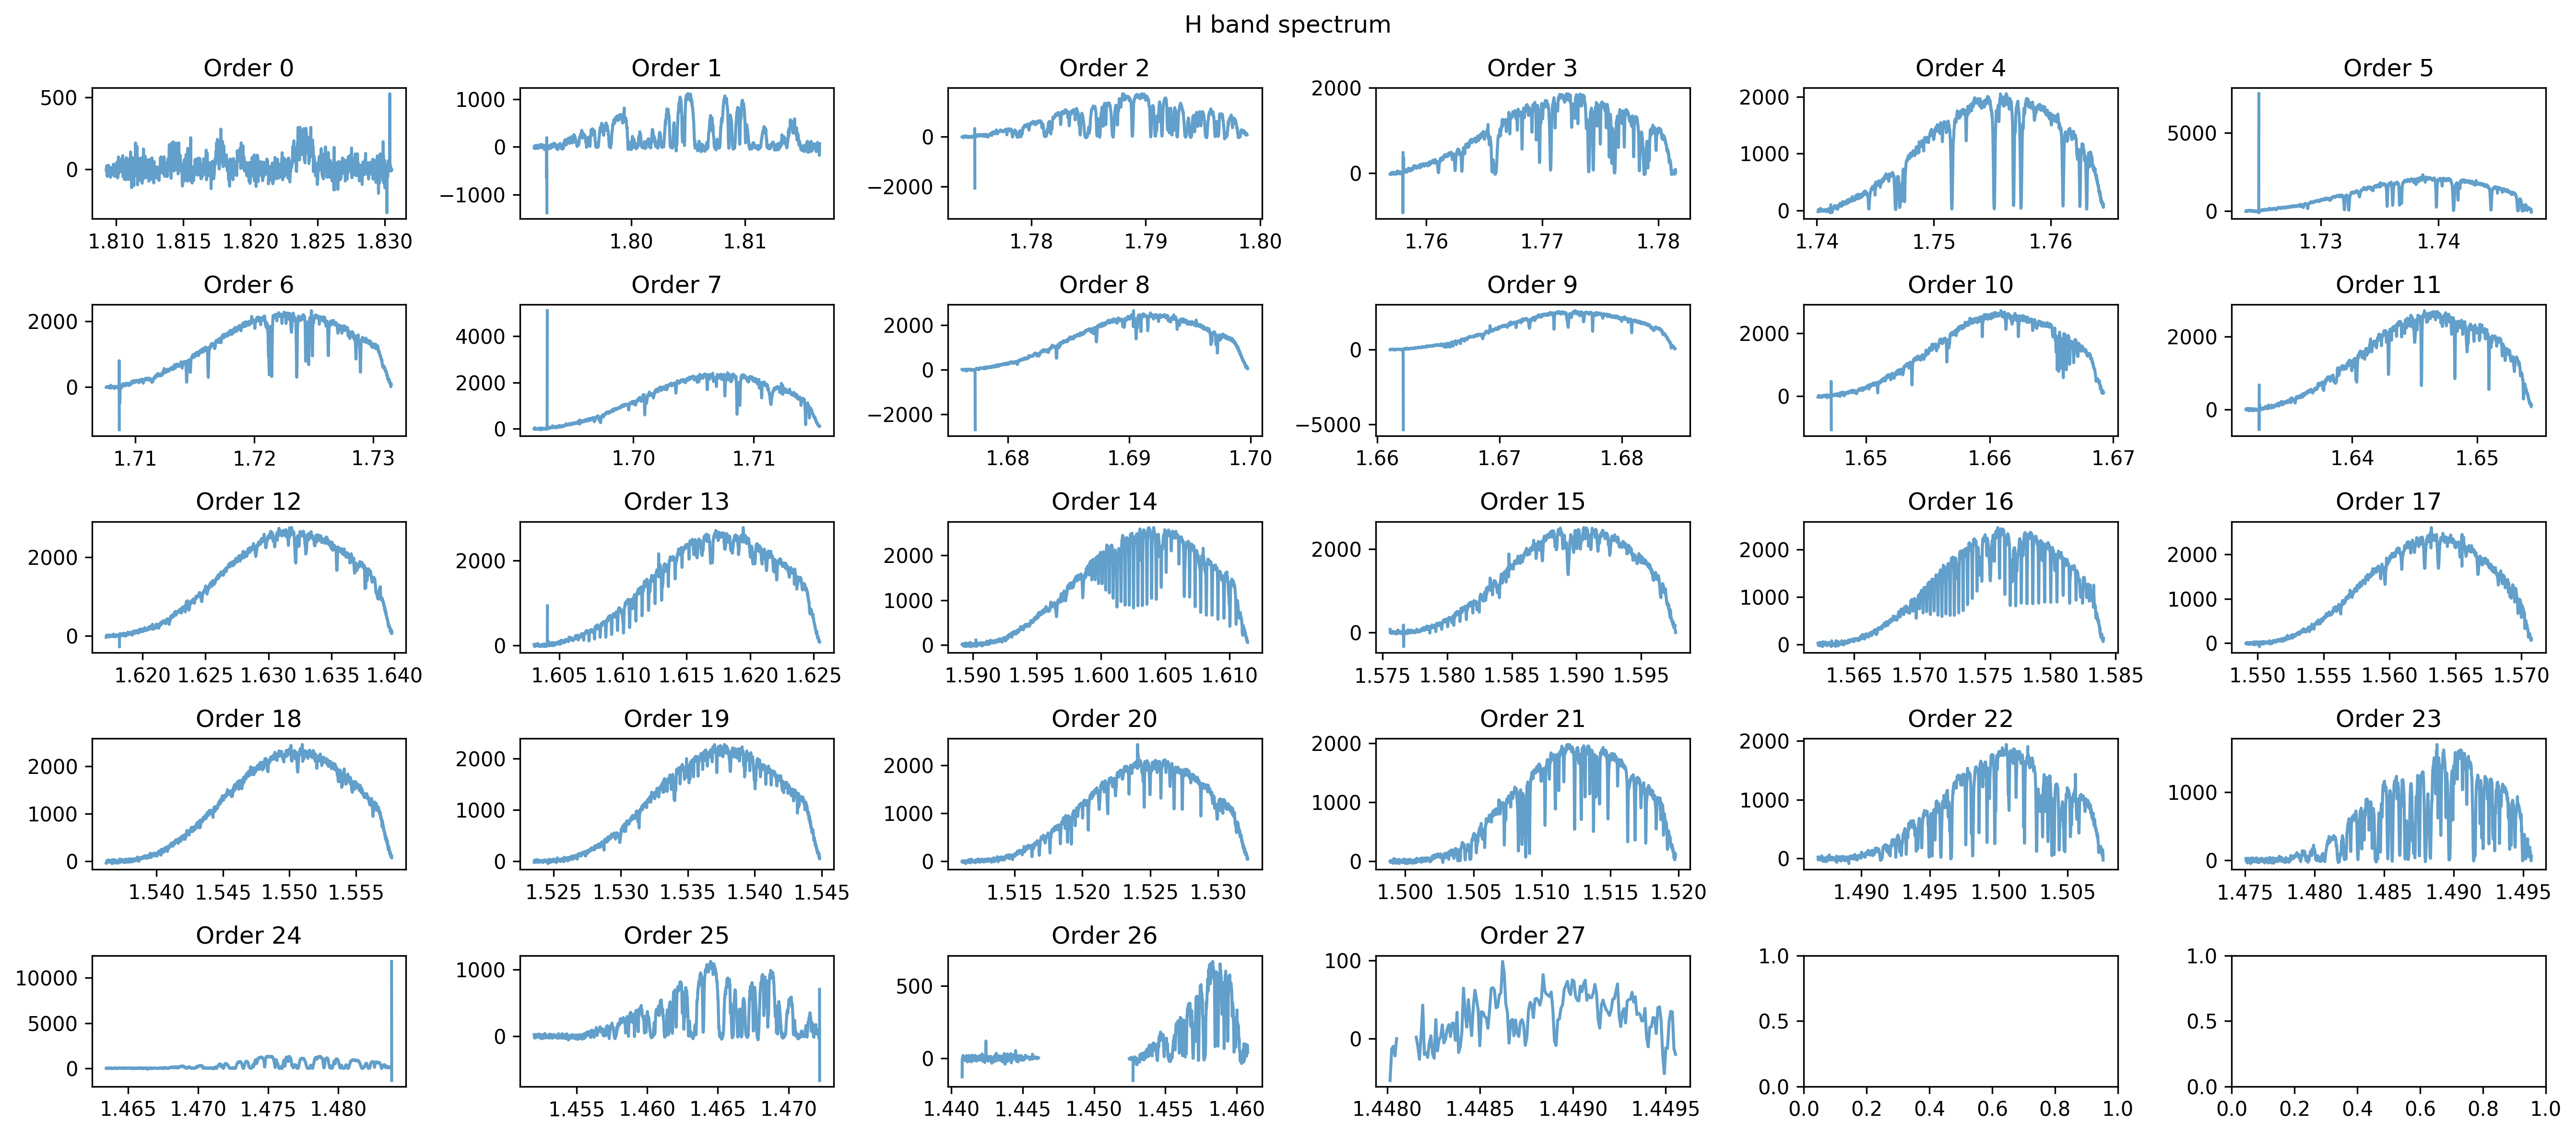

In [9]:
plot_orders(wave_h, spec_h, title='H band spectrum')

### K band

Filename: /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/reduced/SDCK_20230628_0026.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     304   (2048, 26)   float32   
  1                1 ImageHDU       198   (2048, 26)   float64   


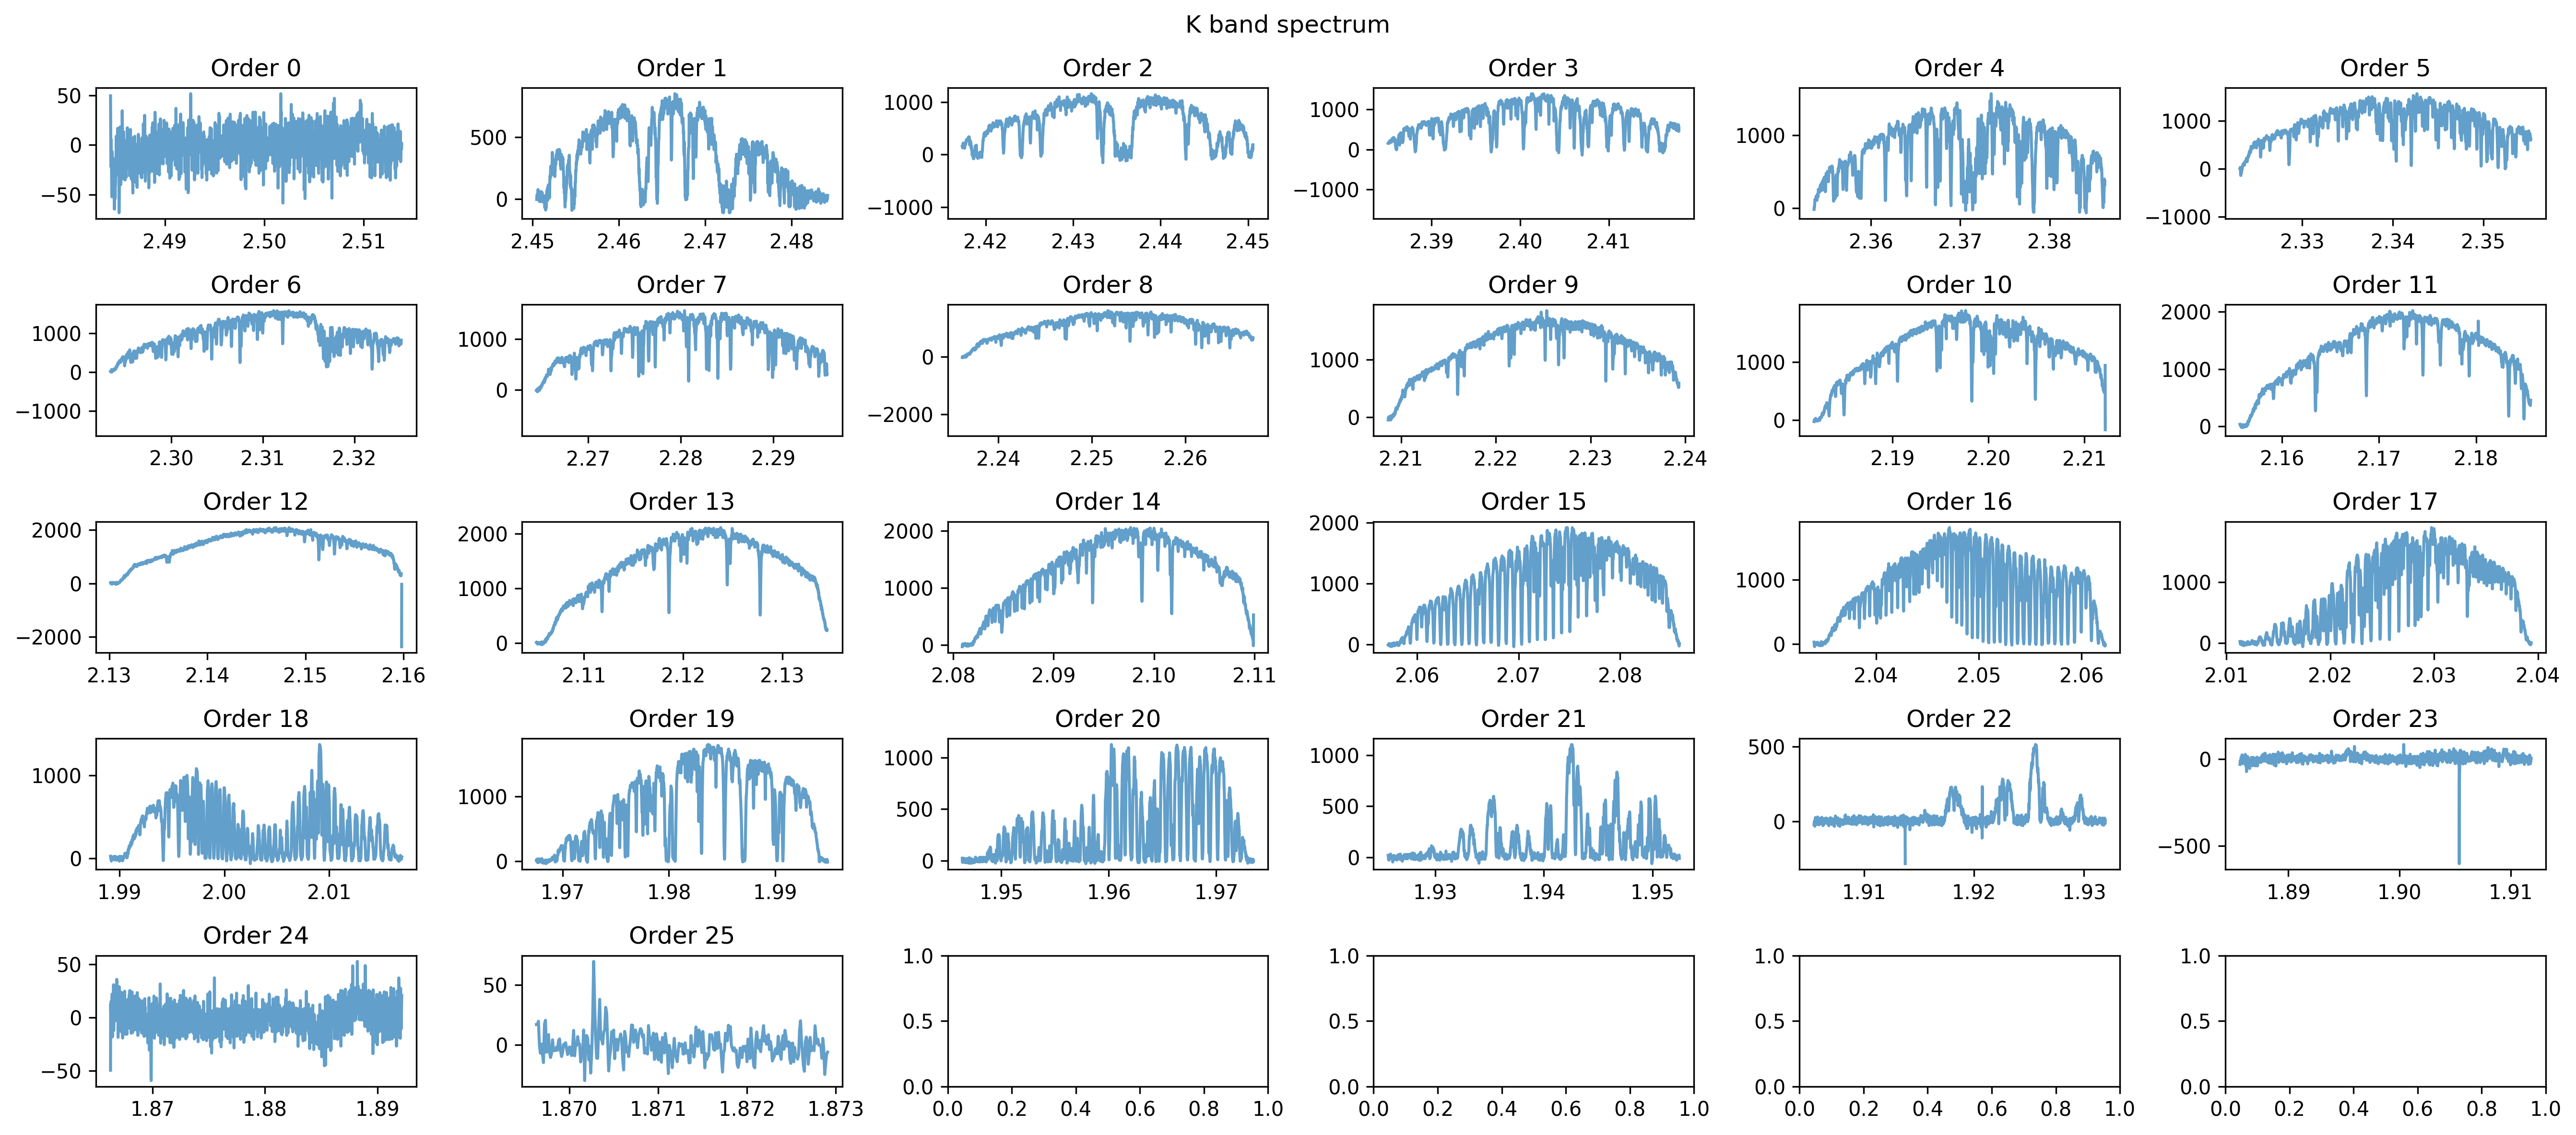

In [10]:
path = '/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/raw_red_data/reduced'
p=path/Path('SDCK_20230628_0026.spec.fits')
with fits.open(p) as hdu:
    hdu.info()
    h = hdu[0].header
    spec_k = hdu[0].data
    wave_k = hdu[1].data

plot_orders(wave_k, spec_k, title='K band spectrum')

## Make files needed

### Blaze function

In [14]:
from astropy.convolution import interpolate_replace_nans, Box1DKernel
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from astropy.convolution import convolve
from scipy.signal import find_peaks

def find_max_continuous_nan(values):
    max_streak = 0
    current_streak = 0

    for value in values:
        if np.isnan(value):
            current_streak += 1
        else:
            max_streak = max(max_streak, current_streak)
            current_streak = 0

    max_streak = max(max_streak, current_streak)

    return max_streak

def find_func(obs, wavelength, order, crop=(None,None), telluric=None, fit_order=8,peak_prominence=0.0001):

    print('Finding........')
    
    blaze_order = obs[order]  # one order of uncorrected blaze function
    wave_order = wavelength[order]
    wave_order_ori = wavelength[order]

    print('blaze order is ', blaze_order)
    print('wave_order is ', wave_order)

    nan_array = np.full(blaze_order.shape, np.nan)

    my_slice = slice(*crop)
    blaze_order = blaze_order[my_slice]  # one order of uncorrected blaze function
    wave_order = wave_order_ori[my_slice]
    
    # clear the nan in the original blaze function with telluric
    blaze_order_nonan = interpolate_replace_nans(blaze_order, Box1DKernel(find_max_continuous_nan(blaze_order)+1))
    nan_num = np.sum(np.isnan(blaze_order_nonan))

    if nan_num > 0:
        raise ValueError(f"The data contains {nan_num} NaN values. Clean the data before applying the method.")

    if telluric is None:
        telluric = blaze_order_nonan
    else: # telluric function passed
        telluric = telluric[order]
        telluric = telluric[my_slice]
    
    
    pos, _ = find_peaks(telluric, prominence=(None, peak_prominence))
    print('position is ', pos)
    coeffs = np.polyfit(wave_order[pos], blaze_order_nonan[pos],fit_order)
    bl_fit = np.polyval(coeffs, wave_order)
    bl_fit = np.clip(bl_fit, 0, None) # perform clip

    nan_array[my_slice]=bl_fit

    return wave_order_ori, nan_array

(array([   0,    1,    2,    3, 2044, 2045, 2046]),)
228


/home/ldang05/venv/ss-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


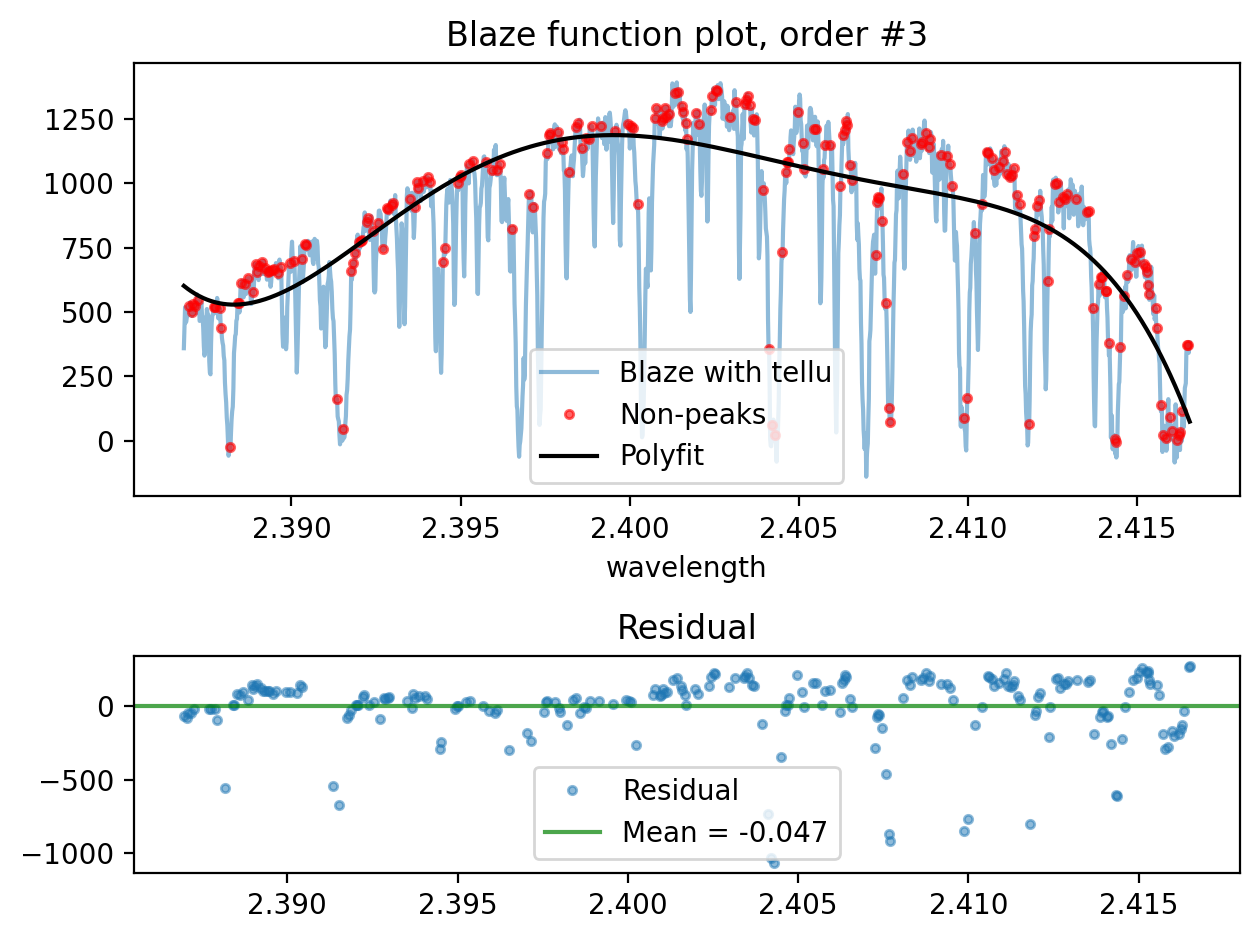

In [23]:
# Test the parameter: e.g. prominence
order=3
blaze_order = spec_k[order] # one order of uncorrected blaze function
wave_order = wave_k[order]
print(np.nonzero(np.isnan(blaze_order)))

blaze_order = blaze_order[100:-100] # one order of uncorrected blaze function
wave_order = wave_order[100:-100]

from astropy.convolution import interpolate_replace_nans, Box1DKernel
blaze_order_nonan = interpolate_replace_nans(blaze_order, Box1DKernel(find_max_continuous_nan(blaze_order)+1))

from scipy.signal import find_peaks
peaks, _ = find_peaks(blaze_order_nonan, prominence=(None, 50)) # peaks returns the position of the peak
coeffs = np.polyfit(wave_order[peaks], blaze_order_nonan[peaks],8)
print(len(peaks))

# Evaluate the polynomial at the generated points
y_fit = np.polyval(coeffs, wave_order)
res = blaze_order_nonan[peaks] - y_fit[peaks]

f1,ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [2, 1]},dpi=200)
ax[0].plot(wave_order, blaze_order_nonan,label='Blaze with tellu',alpha=0.5)
ax[0].plot(wave_order[peaks], blaze_order_nonan[peaks], ".", color='r',label='Non-peaks',alpha=0.6)
ax[0].plot(wave_order,y_fit,color='k',label='Polyfit')
ax[0].set(title='Blaze function plot, order #{}'.format(order),xlabel='wavelength')
ax[0].legend()

ax[1].plot(wave_order[peaks],res, '.', label='Residual',alpha=0.5)
ax[1].axhline(np.mean(res), color='g',label='Mean = {:.3f}'.format(np.mean(res)), alpha=0.7)
ax[1].set_title('Residual')
ax[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# H band
# blaze_func_arr = np.empty((0, np.shape(spec)[1]));
# orders = range(np.shape(spec)[0])
blaze_func_arr1 = np.empty((0,2048))
blaze_func_arr2 = np.empty((0,2048))
H_orders = range(28)
K_orders = range(26)
crop = (100, -100)

for order in H_orders:
    _, b1 = find_func(spec_h, wave_h, order, crop, telluric=None, peak_prominence=50);
    blaze_func_arr1 = np.vstack((blaze_func_arr1, b1));

for order in K_orders:
    _, b2 = find_func(spec_k, wave_k, order, crop, telluric=None, peak_prominence=50);
    blaze_func_arr2 = np.vstack((blaze_func_arr2, b2));

h_tc = blaze_func_arr1
k_tc = blaze_func_arr2

np.sum(np.isnan(h_tc[0])) # number of nan in the result blaze function in order to match the shape of the wave

Finding........
blaze order is  [        nan  -1.4483624 -15.4140625 ...         nan         nan
         nan]
wave_order is  [1.80924239 1.8092565  1.8092706  ... 1.83462948 1.83464078 1.83465208]
position is  [   3   35   38   63   79  104  107  115  117  120  128  143  155  163
  165  168  170  172  179  182  185  190  203  208  210  220  232  237
  240  248  262  273  279  286  289  294  299  305  308  318  323  340
  348  360  369  373  384  393  400  422  424  434  444  461  464  476
  481  491  495  500  503  505  510  512  519  523  528  531  538  549
  556  558  565  574  588  592  599  602  611  624  626  634  638  640
  643  650  670  680  688  698  704  708  711  715  722  724  726  739
  752  760  764  778  792  799  825  835  849  852  863  869  875  881
  883  887  889  896  925  928  946  948  954  958  968  973  980  983
  985  990  992 1013 1024 1029 1047 1052 1056 1077 1082 1092 1096 1099
 1109 1115 1118 1120 1123 1135 1142 1146 1154 1157 1161 1177 1180 1195
 1205 12

/tmp/ipykernel_3323817/1363368419.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop

[      nan 49.52303  10.502229 ...       nan       nan       nan]
wave_order is  [2.48452167 2.48454034 2.48455901 ... 2.51864316 2.51865794 2.51867272]
position is  [   1    7    9   15   18   21   23   25   30   34   39   43   46   49
   52   54   57   62   67   70   73   79   83   89   94   98  102  104
  107  111  113  115  118  121  124  128  136  148  152  158  161  168
  179  182  184  187  189  191  193  198  201  204  207  211  214  217
  220  223  226  231  234  238  242  245  247  249  252  257  262  266
  269  271  274  281  291  293  296  304  306  308  312  318  323  330
  332  336  346  351  359  364  367  369  371  375  379  384  395  398
  401  404  406  409  411  415  418  421  424  427  431  436  440  442
  444  446  451  454  458  462  466  473  475  482  485  492  494  498
  504  510  515  517  520  523  526  529  532  537  540  542  544  547
  553  557  560  566  569  572  574  577  581  585  591  593  597  600
  604  607  610  614  617  619  621  623  628  637  6

/tmp/ipykernel_3323817/1363368419.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=None, peak_prominence=50);
/tmp/ipykernel_3323817/1363368419.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop

200

In [20]:
# Create separate fits files that contains H band and K band blaze function.

h_primary_hdu = fits.PrimaryHDU(h_tc)
h_hdulist = fits.HDUList([h_primary_hdu])
h_hdulist.writeto(Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/H_blaze_function.fits'), overwrite=True)

k_primary_hdu = fits.PrimaryHDU(k_tc)
k_hdulist = fits.HDUList([k_primary_hdu])
k_hdulist.writeto(Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/K_blaze_function.fits'), overwrite=True)

#### Find best blaze function (since no a0v, select 10 orders by eye and ensemble average)

Filename: /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/H_blaze_function.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (2048, 28)   float64   
Filename: /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/K_blaze_function.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (2048, 26)   float64   


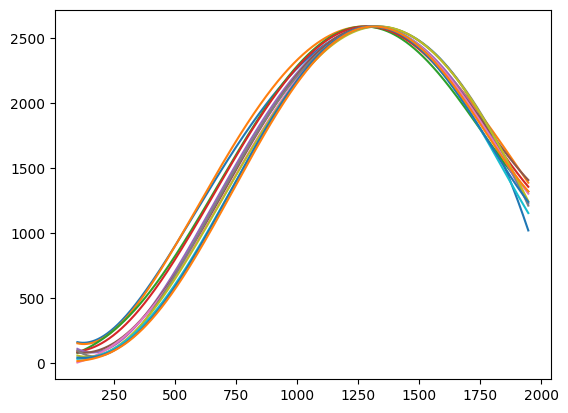

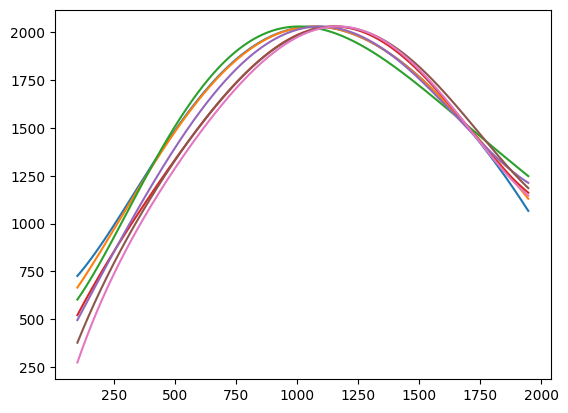

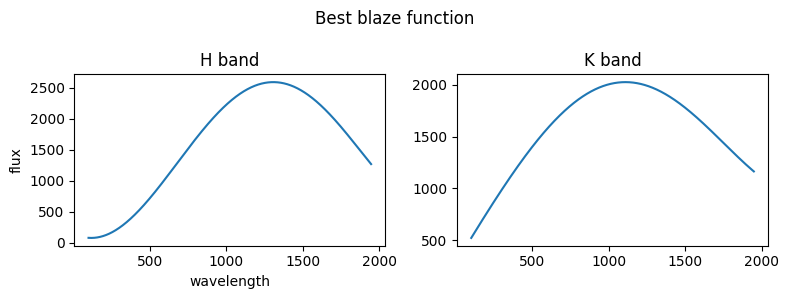

In [21]:
def find_best_blaze(num_order, path, good_idx=None):
    
    with fits.open(path) as hdu:
        hdu.info()
        b=hdu[0].data

    good_blaze = b[good_idx]
    blaze_max = np.nanmax(good_blaze)
    good_blaze = good_blaze/np.nanmax(good_blaze,axis=1)[:,None]
    good_blaze *= blaze_max
    ens_avg = np.mean(good_blaze, axis=0) # shape = (2048,)

    plt.figure()
    plt.plot(good_blaze.T)

    return ens_avg

p=Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/H_blaze_function.fits')
good_idx=[5,6,7,8,12,13,14,15,16,17,18,19]
H_best_blaze = find_best_blaze(10,p, good_idx)

p=Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/K_blaze_function.fits')
good_idx=[7,9,10,11,12,13,14]
K_best_blaze = find_best_blaze(10,p, good_idx)

f1,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(H_best_blaze)
ax[0].set(title='H band', xlabel='wavelength', ylabel='flux')
ax[1].plot(K_best_blaze)
ax[1].set(title='K band')
plt.suptitle('Best blaze function')
plt.tight_layout()

#### Telluric estimate

In [24]:
# H_telluric = H_blaze/H_best_blaze # shape = 28, 2048
# K_telluric = K_blaze/H_best_blaze # shape = 26, 2048

H_bad = [0,1,2,3,23,24,25,26,27]
K_bad = [0,1,2,3,4,6,15,16,18,20,21,22,23,24,25]
H_order = list(range(28))
K_order = list(range(26))
H_telluric = np.empty((0,2048))
K_telluric = np.empty((0,2048))

p = '/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/H_blaze_function.fits'
with fits.open(p) as hdu:
    b=hdu[0].data

    for order in H_order:
        if order in H_bad:
            t=spec_h[order]/H_best_blaze
            H_telluric = np.vstack((H_telluric, t))
        else:
            t = spec_h[order]/b[order]
            H_telluric = np.vstack((H_telluric, t))


p = '/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/K_blaze_function.fits'
with fits.open(p) as hdu:
    b=hdu[0].data

    for order in K_order:
        if order in K_bad:
            t=spec_k[order]/K_best_blaze
            K_telluric = np.vstack((K_telluric, t))
        else:
            t = spec_k[order]/b[order]
            K_telluric = np.vstack((K_telluric, t))# H_telluric = H_blaze/H_best_blaze # shape = 28, 2048


/tmp/ipykernel_3323817/3617207661.py:20: RuntimeWarning: divide by zero encountered in divide
  t = spec_h[order]/b[order]


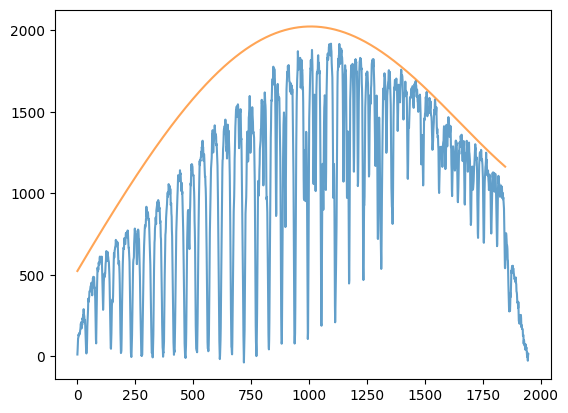

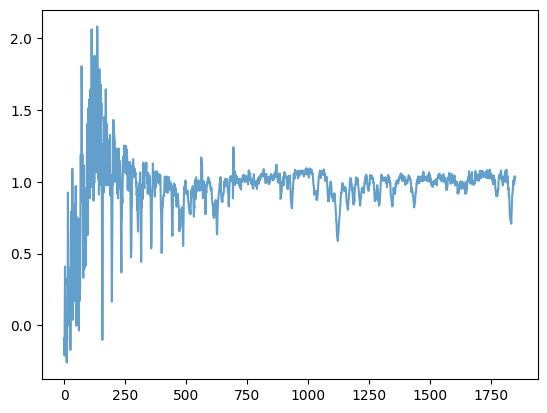

In [25]:
plt.figure()
# plt.plot(spec_h[14],alpha=0.7)
plt.plot(spec_k[15][100:],alpha=0.7)
plt.plot(K_best_blaze[100:],alpha=0.7)

plt.figure()
plt.plot(H_telluric[15][100:],alpha=0.7)

In [26]:
# Create separate fits files that contains H band and K band blaze function.

h_primary_hdu = fits.PrimaryHDU(H_telluric)

h_hdulist = fits.HDUList([h_primary_hdu])
h_hdulist.writeto(Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/H_tellu_recon.fits'), overwrite=True)

k_primary_hdu = fits.PrimaryHDU(K_telluric)
k_hdulist = fits.HDUList([k_primary_hdu])
k_hdulist.writeto(Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/K_tellu_recon.fits'), overwrite=True)

### Blaze function with telluric improvement

In [27]:
# H band
# blaze_func_arr = np.empty((0, np.shape(spec)[1]));
# orders = range(np.shape(spec)[0])
blaze_func_arr1 = np.empty((0,2048))
blaze_func_arr2 = np.empty((0,2048))
H_orders = range(28)
K_orders = range(26)
crop = (100, -100)

for order in H_orders:
    _, b1 = find_func(spec_h, wave_h, order, crop, telluric=H_telluric, peak_prominence=50);
    blaze_func_arr1 = np.vstack((blaze_func_arr1, b1));

for order in K_orders:
    _, b2 = find_func(spec_k, wave_k, order, crop, telluric=K_telluric, peak_prominence=50);
    blaze_func_arr2 = np.vstack((blaze_func_arr2, b2));

h_tc = blaze_func_arr1
k_tc = blaze_func_arr2

np.sum(np.isnan(h_tc[0]))

Finding........
blaze order is  [        nan  -1.4483624 -15.4140625 ...         nan         nan
         nan]
wave_order is  [1.80924239 1.8092565  1.8092706  ... 1.83462948 1.83464078 1.83465208]
position is  [   3    8   13   20   23   27   31   35   38   41   45   51   54   58
   63   66   74   79   82   85   89   96  101  104  107  110  115  117
  120  125  128  134  138  143  147  150  155  159  163  165  168  170
  172  176  179  183  185  190  194  197  203  205  208  210  214  220
  222  229  232  235  237  240  243  248  251  255  262  264  270  273
  276  279  281  286  289  294  296  299  303  305  308  311  318  320
  323  328  331  337  340  346  348  354  360  363  369  373  375  378
  384  388  393  396  400  403  408  411  415  419  422  424  427  431
  434  437  444  447  451  457  461  464  466  473  476  481  486  489
  491  495  500  503  505  508  510  512  515  517  519  523  528  531
  535  538  541  545  549  553  556  558  561  565  567  572  574  577
  582  5

/tmp/ipykernel_3323817/1988168324.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=H_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=H_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=H_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=H_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_func(spec_h, wave_h, order, crop, telluric=H_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:11: RankWarning: Polyfit may be poorly conditioned
  _, b1 = find_fu

position is  [   3    5    8   10   13   17   22   35   38   42   45   49   51   54
   58   62   65   71   73   76   79   81   83   88   93   98  101  104
  108  112  117  120  126  128  130  134  140  142  145  147  151  155
  178  181  184  188  192  196  200  205  213  215  220  223  227  229
  231  236  239  241  245  247  251  254  257  260  263  275  277  279
  283  295  298  301  304  306  311  316  319  322  325  330  346  349
  355  363  370  377  379  382  386  388  392  399  409  412  423  429
  431  438  443  451  453  457  461  465  467  470  472  474  479  481
  489  491  500  503  506  508  511  514  519  523  528  531  533  540
  544  546  549  552  555  557  560  563  566  568  570  573  578  583
  590  594  599  601  605  609  614  618  620  622  625  627  631  636
  642  645  652  658  661  664  668  671  675  678  683  688  691  694
  699  701  706  709  712  716  719  723  729  732  734  740  746  751
  754  757  760  765  768  772  775  777  800  807  813  823  83

/tmp/ipykernel_3323817/1988168324.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=K_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=K_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=K_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=K_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_func(spec_k, wave_k, order, crop, telluric=K_telluric, peak_prominence=50);
/tmp/ipykernel_3323817/1988168324.py:15: RankWarning: Polyfit may be poorly conditioned
  _, b2 = find_fu

200

In [28]:
# Create separate fits files that contains H band and K band blaze function.

h_primary_hdu = fits.PrimaryHDU(h_tc)
h_hdulist = fits.HDUList([h_primary_hdu])
h_hdulist.writeto(Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/H_telluric_corr.fits'), overwrite=True)

k_primary_hdu = fits.PrimaryHDU(k_tc)
k_hdulist = fits.HDUList([k_primary_hdu])
k_hdulist.writeto(Path('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/K_telluric_corr.fits'), overwrite=True)

### Combine spectra of H and K band

In [ ]:
# In terminal,

# ls /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/raw_red_data/reduced/SDCH_20230628_*.spec.fits > /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/list_SDCH_spec.txt
# ls /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/raw_red_data/reduced/SDCK_20230628_*.spec.fits > /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/list_SDCK_spec.txt

# mkdir COMBINED_HK_SPEC

In [31]:
path='/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/'
# Read the first text file containing file paths
with open(path/Path('list_SDCH_spec.txt'), 'r') as file1:
    file_paths1 = file1.read().splitlines()

# Read the second text file containing file paths
with open(path/Path('list_SDCK_spec.txt'), 'r') as file2:
    file_paths2 = file2.read().splitlines()

# Iterate over the file paths and stack the FITS data
for path1, path2 in zip(file_paths1, file_paths2):
    # Open the first FITS file and extract data
    exp_time = path1[-14:]
    filename = f'/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/COMBINED_HK_SPEC/{exp_time}'

    with fits.open(path1) as fits_file1:
        # fits_file1.info()
        data1 = fits_file1[0].data
        wv1 = fits_file1[1].data
        header1 = fits_file1[0].header  # Get the header of path1

    # Open the second FITS file and extract data
    with fits.open(path2) as fits_file2:
        data2 = fits_file2[0].data
        wv2 = fits_file2[1].data

    # Stack the data from both files
    combined_data = np.vstack((data1, data2))
    combined_wv = np.vstack((wv1, wv2))

    # Save the combined data as a new FITS file
    primary_hdu = fits.PrimaryHDU(combined_data, header=header1)
    wv_hdu = fits.ImageHDU(combined_wv)

    hdul = fits.HDUList([primary_hdu, wv_hdu])
    hdul.writeto(filename, overwrite=True)

    # Append the new FITS file path to another text file
    with open(path/Path('list_SDCHK_spec.txt'), 'a') as combined_files:
        combined_files.write(filename + '\n')

In [32]:
# Check one combined fits file

with fits.open('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/COMBINED_HK_SPEC/0026.spec.fits') as fits_file:
    # Access the header or data as needed
    fits_file.info()
    header = fits_file[0].header
    data = fits_file[0].data
    wv = fits_file[1].data

    # Perform any desired checks or analysis on the FITS file
    print("FITS file information:")
    print(header)
    print("Data shape:", data.shape)

Filename: /home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/COMBINED_HK_SPEC/0026.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     310   (2048, 54)   float32   
  1                1 ImageHDU         7   (2048, 54)   float64   
FITS file information:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                   54                                                  EXTEND  =                    T                                                  I_HDRVER= '0.995   '           / version of IGRINS FITS Header                  OBSERVAT= 'Gemini Observatory' / Name of the observatory                        TELESCOP= 'Gemini South'       / Name 

### Combine blaze function of H and K band

In [33]:
path='/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b_230628/'

In [34]:
# Open the first FITS file
fits_file1 = fits.open(path/Path('H_telluric_corr.fits'))
data1 = fits_file1[0].data
print(np.shape(data1))

# Open the second FITS file
fits_file2 = fits.open(path/Path('K_telluric_corr.fits'))
data2 = fits_file2[0].data
print(np.shape(data2))

# Combine the data from both files
combined_data = np.vstack((data1, data2))
print(np.shape(combined_data))

# Create a new FITS file and save the combined data
combined_hdu = fits.PrimaryHDU(combined_data)
combined_hdulist = fits.HDUList([combined_hdu])
combined_hdulist.writeto(path/Path('HK_tellu_corrected_blaze_func.fits'), overwrite=True)

# Close the opened FITS files
fits_file1.close()
fits_file2.close()

(28, 2048)
(26, 2048)
(54, 2048)
